# Chapter11. 聚类分析
- 使用k-means算法发现簇中心
- 使用自底向上的方法构建决策树
- 基于密度聚类方法发现任意形状簇

In [14]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -v -p numpy,pandas,matplotlib,scipy,sklearn

Sebastian Raschka 
last updated: 2018-10-19 

CPython 3.6.6
IPython 7.0.1

numpy 1.15.2
pandas 0.23.4
matplotlib 3.0.0
scipy 1.1.0
sklearn 0.20.0


## 1. 使用k-means算法对相似对象进行分组

In [9]:
from sklearn.datasets import make_blobs
%matplotlib inline

X, y = make_blobs(n_samples=150, 
                  n_features=2,
                  centers=3,
                  cluster_std=0.5,
                  shuffle=True,
                  random_state=0)

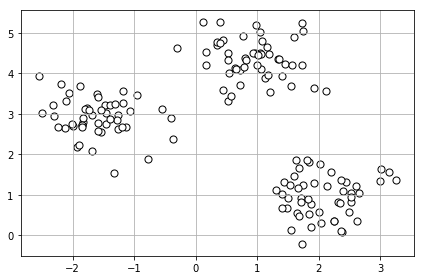

In [16]:
import matplotlib.pyplot as plt

# 新版本的matplotlib的scatter方法需要添加edgecolors来显示点的边缘
plt.scatter(X[:, 0], X[:, 1], c='white', marker='o', edgecolors='black', s=50)
plt.grid()
plt.tight_layout()
plt.show()

k-means算法：
1. 从样本点中随机选择k个点作为初始簇中心；
2. 将每个样本点划分到距离它最近的中心点 $\mu^{(j)},j\in\{1,...,k\}$ 所代表的簇中；
3. 用各簇中所有样本的中心点（求均值）替代原有的中心点；
4. 重复步骤2和3，直到中心点不变或达到迭代次数。

In [19]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3,
            init='random',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_km = km.fit_predict(X)
# 输出所有点所属的聚类中心
print(y_km)

[1 0 0 0 1 0 0 1 2 0 1 2 2 0 0 2 2 1 2 1 0 1 0 0 2 1 1 0 2 1 2 2 2 2 0 1 1
 1 0 0 2 2 0 1 1 1 2 0 2 0 1 0 0 1 1 2 0 1 2 0 2 2 2 2 0 2 0 1 0 0 0 1 1 0
 1 0 0 2 2 0 1 1 0 0 1 1 1 2 2 1 1 0 1 0 1 0 2 2 1 1 1 1 2 1 1 0 2 0 0 0 2
 0 1 2 0 2 0 0 2 2 0 1 0 0 1 1 2 1 2 2 2 2 1 2 2 2 0 2 1 2 0 0 1 1 2 2 2 2
 1 1]


### a. k-means++
k-means++：
1. 初始化一个空集合 $\bf M$，用于存储选定的 $k$ 个中心点；
2. 从输入样本中随机选定第一个中心点 $\mu^{(j)}$，将其加入集合 $\bf M$ 中；
3. 对于集合 $\bf M$ 之外的任一样本点 ${\bf x}^{(j)}$，通过计算找到与其平方距离最小的样本 $d({\bf x}^{(i)}, {\bf M})^2$；
4. 使用加权概率分布 $\frac{d({\bf \mu}^{(p)}, {\bf M})^2}{\sum_id({\bf x}^{(i)}, {\bf M})^2}$来随机选择下一个中心点 $\mu^{(p)}$；
5. 重复步骤2，3，直到选定 $k$ 个中心点；
6. 基于选定的 $k$ 个中心点执行k-means算法；

k-means++算法可以让初始中心点彼此尽可能的远离，相比传统的k-means算法，它可以获得更好、更一致的结果。

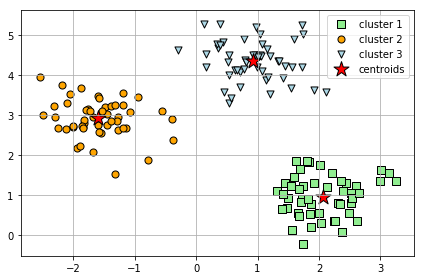

In [21]:
km = KMeans(n_clusters=3, 
            init='k-means++',
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_km = km.fit_predict(X)

plt.scatter(X[y_km == 0, 0], X[y_km == 0, 1],
            s=50, color='lightgreen', edgecolors='black',
            marker='s', label='cluster 1')

plt.scatter(X[y_km == 1, 0], X[y_km == 1, 1],
            s=50, color='orange', edgecolors='black',
            marker='o', label='cluster 2')

plt.scatter(X[y_km == 2, 0], X[y_km == 2, 1],
            s=50, color='lightblue', edgecolors='black',
            marker='v', label='cluster 3')

plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250, marker='*',
            color='red', edgecolors='black',
            label='centroids')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

k-means在简单数据集上运行良好，但是也有缺点：
- 我们必须指定先验的簇数量k，但在实际中，这往往是不可知的。
- 簇不可重叠，也不可分层，并且假定了每个簇至少会有一个样本

### b. 硬聚类和软聚类
硬聚类（hard clustering）指的是数据集中每个样本只能划分到一个簇。软聚类（soft clustering），也成模糊聚类可以将一个样本划分到一个或多个簇。常见的软聚类算法是C-means（fuzzy C-means，FCM）。具体算法参见p199。

### c. 使用肘方法确定簇的最佳数量
在完成KMeans拟合后，簇内误差平方和可以直接通过inertia属性来访问：

In [22]:
print("Distortion: %.2f" % km.inertia_)

Distortion: 72.48


基于簇内误差平方和我们可以使用图像工具，即肘方法针对给定任务估计出最优的簇数量k。直观来看，增加k的值可以降低聚类偏差。肘方法的基本理念就是找出聚类偏差骤增时k的值。

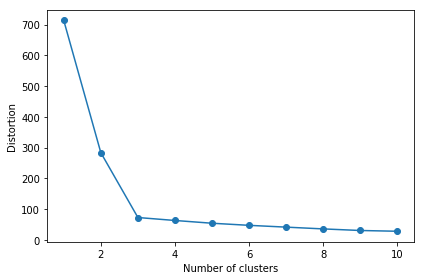

In [23]:
distortion = []
for i in range(1, 11):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(X)
    distortion.append(km.inertia_)
    
plt.plot(range(1, 11), distortion, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

可以看到，$k=3$时，图案呈现了肘形，表明对此数据集来说，$k=3$是一个较好的选择。

### d. 通过轮廓图定量分析聚类质量
另一种评估聚类质量的定量分析方法是轮廓分析（silhouette analysis）。轮廓分析可以使用一个图形工具来度量簇中样本聚集的密集程度：
1. 将某一样本 ${\bf x}^{(i)}$ 与簇内其他点之间的平均距离看做是簇的内聚度 $a^{(i)}$；
2. 将样本 ${\bf x}^{(i)}$ 与其最近簇中所有点之间的平均距离看作是下一最近簇的分离度 $b^{(i)}$；
3. 将簇分离度与簇内聚度之差除以二者之中较大者得到轮廓系数：

    $$s^{(i)} = \frac{b^{(i)}-a^{(i)}}{max\{b^{(i)}, a^{(i)}\}}$$
    
轮廓系数介于-1到1之间，簇内聚度和分离度相等（$b^{(i)}=a^{(i)}$），则轮廓系数值为0。由于 $b^{(i)}$ 衡量样本与其他簇的样本之间的差异程度，$a^{(i)}$ 衡量样本与本簇内样的相似程度，所以如果 $b^{(i)}>>a^{(i)}$，那么就可以得到一个近似1的理想值。

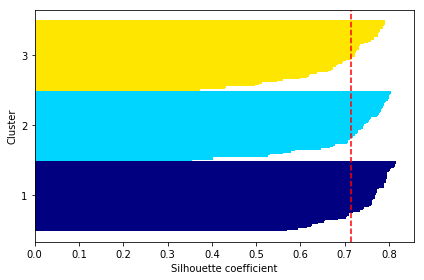

In [31]:
import numpy as np
from matplotlib import cm
# 计算每个样本的轮廓系数
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=3,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
# 每个样本的轮廓系数
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    # 第c个簇的样本轮廓系数
    c_silhouette_vals = silhouette_vals[y_km == c]
    # 递增排列
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    # barh绘制水平条形图
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
             edgecolor='none', color=color)
    
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
# 绘制垂直线
plt.axvline(silhouette_avg, color='red', linestyle='--')

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
plt.show()

从图中可以看到轮库系数均未接近0点，所以聚类效果不错。

为了了解效果不佳的轮廓图，我们使用两个聚类中心来初始化k-means算法：

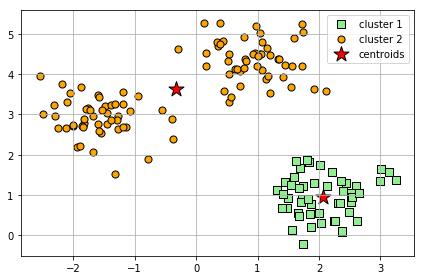

In [32]:
km = KMeans(n_clusters=2,
            init='k-means++',
            n_init=10,
            max_iter=300, 
            tol=1e-04, 
            random_state=0)
y_km = km.fit_predict(X)

plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50,
            c='lightgreen',
            marker='s',
            label='cluster 1',
            edgecolors='black')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50,
            c='orange',
            marker='o',
            label='cluster 2',
            edgecolors='black')

plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=250, 
            marker='*', color='red', edgecolors='black', label='centroids')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

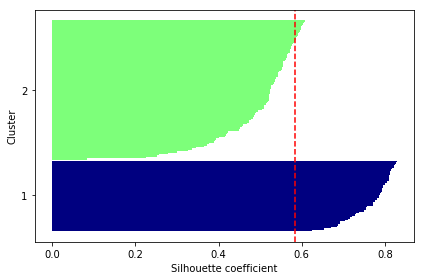

In [38]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)
    
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color='red', linestyle='--')

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
plt.show()

从图中可见，轮廓明显有着不同的长度，说明效果不佳

## 2. 层次聚类
层次聚类允许我们绘制树状图，有助于我们解释聚类结果，而且层次聚类无需事先指定簇的数量。层次聚类主要有两种方法：凝聚层次聚类和分裂层次聚类。在分裂层次聚类中，我们首先把所有样本看做同一个簇，然后迭代地将簇划分为更小的簇，直到每个簇只包含一个样本。凝聚层次聚类则相反，最初我们把每个样本都看作一个单独的簇，重复地将最近的簇进行合并，直到所有样本都在一个簇中为止。

凝聚层次聚类中，判定簇间距离的两个标准方法是单连接和全连接：
1. 计算得到所有样本间的距离矩阵；
2. 将每个数据点看作是一个单独的簇；
3. 基于最不相似（距离最远）样本的距离，合并两个最接近的簇；
4. 更新相似矩阵；
5. 重复2到4，知道所有样本都合并到一个簇为止。

In [40]:
import pandas as pd
import numpy as np

np.random.seed(123)

variables = ['X', 'Y', 'Z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']

X = np.random.random_sample([5, 3]) * 10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


### a. 基于距离矩阵进行层次聚类

In [41]:
from scipy.spatial.distance import pdist, squareform

row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')),
                        columns=labels,
                        index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


我们使用Scipy中的cluster.hierarchy子模块下的linkage函数，它以全连接作为距离判定标准，返回一个关联矩阵：

In [43]:
from scipy.cluster.hierarchy import linkage

row_clusters = linkage(row_dist, method='complete', metric='euclidean')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1)
                    for i in range(row_clusters.shape[0])])

/home/tuser/Software/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,6.521973,2.0
cluster 2,1.0,2.0,6.729603,2.0
cluster 3,3.0,5.0,8.539247,3.0
cluster 4,6.0,7.0,12.444824,5.0
